In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [14]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
"""
Remember to change model name (not just torchinfo), shape, fen_to_vector, dataloader, model_save_name
"""
RUN_ID = "run_2025_12_28_giraffe_baseline_with_dropout_state"

In [4]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [5]:
BATCH_SIZE = 2048
num_workers = 0

train_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split_with_state/chess_state_bitboard_train.npz"), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split_with_state/chess_state_bitboard_val.npz"), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split_with_state/chess_state_bitboard_test.npz"), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [6]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.020802435874938966


In [7]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 775]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [8]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [9]:
class GiraffeBaselineWithDropoutWithState(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [10]:
from torchinfo import summary

model = GiraffeBaselineWithDropoutWithState(input_shape=775,
                        hidden_units=2048,
                        output_shape=7) # 7 classes

summary(model, input_size=(2048, 775))

Layer (type:depth-idx)                   Output Shape              Param #
GiraffeBaselineWithDropoutWithState      [2048, 7]                 --
├─Sequential: 1-1                        [2048, 7]                 --
│    └─Linear: 2-1                       [2048, 2048]              1,589,248
│    └─ReLU: 2-2                         [2048, 2048]              --
│    └─Dropout: 2-3                      [2048, 2048]              --
│    └─Linear: 2-4                       [2048, 2048]              4,196,352
│    └─ReLU: 2-5                         [2048, 2048]              --
│    └─Dropout: 2-6                      [2048, 2048]              --
│    └─Linear: 2-7                       [2048, 7]                 14,343
Total params: 5,799,943
Trainable params: 5,799,943
Non-trainable params: 0
Total mult-adds (G): 11.88
Input size (MB): 6.35
Forward/backward pass size (MB): 67.22
Params size (MB): 23.20
Estimated Total Size (MB): 96.77

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [12]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [13]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"{model_save_name}.pth")
        else:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = GiraffeBaselineWithDropoutWithState(input_shape=775,
                                   hidden_units=2048,
                                   output_shape=7).to(device)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

result = run_experiment(model=model,
                        model_save_name="giraffe_baseline_with_dropout_state",
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  1%|          | 1/100 [00:13<22:04, 13.37s/it]

Epoch 0: New Best Val Loss: 1.2031 (Saved)
Epoch: 0 | Train Loss: 0.9930368712186204 | Train Acc: 0.6346896978900256 | Val Loss: 1.2030629819753218 | Val Acc: 0.5637081999663073


  2%|▏         | 2/100 [00:25<21:03, 12.90s/it]

Epoch 1: Train Loss: 0.7187 | Val Loss: 1.3346
Epoch: 1 | Train Loss: 0.7187085657778298 | Train Acc: 0.7264765824808184 | Val Loss: 1.3346013633572325 | Val Acc: 0.5604981784871967


  3%|▎         | 3/100 [00:37<19:55, 12.33s/it]

Epoch 2: Train Loss: 0.6000 | Val Loss: 1.4059
Epoch: 2 | Train Loss: 0.6000251882826276 | Train Acc: 0.7727419177589514 | Val Loss: 1.4058703768010041 | Val Acc: 0.5532068627863882


  4%|▍         | 4/100 [00:48<18:50, 11.77s/it]

Epoch 3: Train Loss: 0.5307 | Val Loss: 1.5157
Epoch: 3 | Train Loss: 0.5307251186017186 | Train Acc: 0.7994325447570333 | Val Loss: 1.5156721387590681 | Val Acc: 0.5556550376636504


  5%|▌         | 5/100 [00:59<18:05, 11.42s/it]

Epoch 4: Train Loss: 0.4841 | Val Loss: 1.5683
Epoch: 4 | Train Loss: 0.48413364044235796 | Train Acc: 0.8180464254315857 | Val Loss: 1.5682693646878612 | Val Acc: 0.5523367181483443


  6%|▌         | 6/100 [01:10<17:37, 11.25s/it]

Epoch 5: Train Loss: 0.4508 | Val Loss: 1.5625
Epoch: 5 | Train Loss: 0.45082020317502036 | Train Acc: 0.8300229279891305 | Val Loss: 1.5625408085025088 | Val Acc: 0.5541548466379476


  7%|▋         | 7/100 [01:21<17:17, 11.15s/it]

Epoch 6: Train Loss: 0.4226 | Val Loss: 1.6299
Epoch: 6 | Train Loss: 0.4225794230885518 | Train Acc: 0.8411459998401535 | Val Loss: 1.6299066786863365 | Val Acc: 0.5548465627406622


  8%|▊         | 8/100 [01:32<16:57, 11.06s/it]

Epoch 7: Train Loss: 0.4011 | Val Loss: 1.6624
Epoch: 7 | Train Loss: 0.40113370962764905 | Train Acc: 0.8490456661604859 | Val Loss: 1.662429731719348 | Val Acc: 0.5520652209881594


  9%|▉         | 9/100 [01:43<16:45, 11.05s/it]

Epoch 8: Train Loss: 0.3830 | Val Loss: 1.7117
Epoch: 8 | Train Loss: 0.3829890084083733 | Train Acc: 0.8558638706841433 | Val Loss: 1.7116692114849479 | Val Acc: 0.5537239107022526


 10%|█         | 10/100 [01:53<16:25, 10.95s/it]

Epoch 9: Train Loss: 0.3677 | Val Loss: 1.7406
Epoch: 9 | Train Loss: 0.36773768006383306 | Train Acc: 0.8616700467551152 | Val Loss: 1.7405874558857508 | Val Acc: 0.5546624936826146


 11%|█         | 11/100 [02:04<16:15, 10.96s/it]

Epoch 10: Train Loss: 0.3559 | Val Loss: 1.7559
Epoch: 10 | Train Loss: 0.3559056730069163 | Train Acc: 0.8661127817295396 | Val Loss: 1.755862019499954 | Val Acc: 0.5544991065412014


 12%|█▏        | 12/100 [02:15<16:05, 10.97s/it]

Epoch 11: Train Loss: 0.3425 | Val Loss: 1.7651
Epoch: 11 | Train Loss: 0.3424622383721344 | Train Acc: 0.8711499460517903 | Val Loss: 1.7651107870802587 | Val Acc: 0.5526031388380824


 13%|█▎        | 13/100 [02:26<15:54, 10.98s/it]

Epoch 12: Train Loss: 0.3318 | Val Loss: 1.8053
Epoch: 12 | Train Loss: 0.3318284993129008 | Train Acc: 0.8749852641464194 | Val Loss: 1.805298316235445 | Val Acc: 0.5548369738520408


 14%|█▍        | 14/100 [02:37<15:45, 11.00s/it]

Epoch 13: Train Loss: 0.3240 | Val Loss: 1.8487
Epoch: 13 | Train Loss: 0.3240459755710933 | Train Acc: 0.8777730878356778 | Val Loss: 1.8487338995446965 | Val Acc: 0.5555409110873123


 15%|█▌        | 15/100 [02:48<15:30, 10.95s/it]

Epoch 14: Train Loss: 0.3139 | Val Loss: 1.8770
Epoch: 14 | Train Loss: 0.31391037554692125 | Train Acc: 0.8817020660166242 | Val Loss: 1.8769631969685456 | Val Acc: 0.55255876672603


 16%|█▌        | 16/100 [02:59<15:19, 10.94s/it]

Epoch 15: Train Loss: 0.3064 | Val Loss: 1.8518
Epoch: 15 | Train Loss: 0.30636361279451024 | Train Acc: 0.8849252217870844 | Val Loss: 1.851796420253053 | Val Acc: 0.5552771226415094


 17%|█▋        | 17/100 [03:10<15:08, 10.94s/it]

Epoch 16: Train Loss: 0.2994 | Val Loss: 1.8920
Epoch: 16 | Train Loss: 0.2993692817819088 | Train Acc: 0.8872467431265986 | Val Loss: 1.8920314968848715 | Val Acc: 0.5545908590440893


 18%|█▊        | 18/100 [03:21<14:58, 10.95s/it]

Epoch 17: Train Loss: 0.2940 | Val Loss: 1.9108
Epoch: 17 | Train Loss: 0.2940297377917468 | Train Acc: 0.8892832880434782 | Val Loss: 1.9107806220346568 | Val Acc: 0.5551592357166923


 19%|█▉        | 19/100 [03:32<14:50, 11.00s/it]

Epoch 18: Train Loss: 0.2855 | Val Loss: 1.9238
Epoch: 18 | Train Loss: 0.28548629174147117 | Train Acc: 0.8920446371483377 | Val Loss: 1.9237519672938757 | Val Acc: 0.5560714962577012


 20%|██        | 20/100 [03:43<14:44, 11.06s/it]

Epoch 19: Train Loss: 0.2816 | Val Loss: 1.9320
Epoch: 19 | Train Loss: 0.2816243760497369 | Train Acc: 0.8937537464034527 | Val Loss: 1.932040119657711 | Val Acc: 0.5559193901617251


 21%|██        | 21/100 [03:55<14:56, 11.35s/it]

Epoch 20: Train Loss: 0.2758 | Val Loss: 1.9095
Epoch: 20 | Train Loss: 0.27579313619514867 | Train Acc: 0.8956004735453964 | Val Loss: 1.9094952563850247 | Val Acc: 0.5508137770143434


 22%|██▏       | 22/100 [04:07<14:50, 11.42s/it]

Epoch 21: Train Loss: 0.2706 | Val Loss: 1.9652
Epoch: 21 | Train Loss: 0.2706350156337099 | Train Acc: 0.8977454144021739 | Val Loss: 1.9652112503441013 | Val Acc: 0.5535479263934348


 23%|██▎       | 23/100 [04:18<14:38, 11.41s/it]

Epoch 22: Train Loss: 0.2679 | Val Loss: 1.9687
Epoch: 22 | Train Loss: 0.2678789275000467 | Train Acc: 0.8988948109814577 | Val Loss: 1.9687346511957597 | Val Acc: 0.554416754909511


 24%|██▍       | 24/100 [04:31<15:01, 11.86s/it]

Epoch 23: Train Loss: 0.2626 | Val Loss: 1.9376
Epoch: 23 | Train Loss: 0.2625589975158272 | Train Acc: 0.9006456301950128 | Val Loss: 1.9375785783845552 | Val Acc: 0.5517674013886215


 25%|██▌       | 25/100 [04:43<14:55, 11.94s/it]

Epoch 24: Train Loss: 0.2589 | Val Loss: 2.0192
Epoch: 24 | Train Loss: 0.2588614424323792 | Train Acc: 0.9022286105338875 | Val Loss: 2.019202390495612 | Val Acc: 0.5537284231204274


 26%|██▌       | 26/100 [04:55<14:27, 11.72s/it]

Epoch 25: Train Loss: 0.2548 | Val Loss: 1.9723
Epoch: 25 | Train Loss: 0.2547687232646796 | Train Acc: 0.9037469029731457 | Val Loss: 1.9722642752589012 | Val Acc: 0.5523199845976127


 27%|██▋       | 27/100 [05:05<13:57, 11.48s/it]

Epoch 26: Train Loss: 0.2510 | Val Loss: 2.0197
Epoch: 26 | Train Loss: 0.25099703696225306 | Train Acc: 0.9052342251438619 | Val Loss: 2.0197412140515385 | Val Acc: 0.5524038403686946


 28%|██▊       | 28/100 [05:17<13:37, 11.36s/it]

Epoch 27: Train Loss: 0.2469 | Val Loss: 2.0449
Epoch: 27 | Train Loss: 0.2468924874920979 | Train Acc: 0.9067884830562659 | Val Loss: 2.0449254172188893 | Val Acc: 0.5557362611907971


 29%|██▉       | 29/100 [05:29<13:43, 11.60s/it]

Epoch 28: Train Loss: 0.2438 | Val Loss: 2.0231
Epoch: 28 | Train Loss: 0.24378782880428196 | Train Acc: 0.9080729999200768 | Val Loss: 2.023101281146614 | Val Acc: 0.551586340609357


 30%|███       | 30/100 [05:41<13:50, 11.87s/it]

Epoch 29: Train Loss: 0.2407 | Val Loss: 2.0513
Epoch: 29 | Train Loss: 0.24071701431213438 | Train Acc: 0.909253616528133 | Val Loss: 2.0513279097420827 | Val Acc: 0.5513795214430112


 31%|███       | 31/100 [05:54<13:50, 12.03s/it]

Epoch 30: Train Loss: 0.2376 | Val Loss: 2.0586
Epoch: 30 | Train Loss: 0.23764004297268665 | Train Acc: 0.909953944213555 | Val Loss: 2.058556237999274 | Val Acc: 0.5522145068227763


 32%|███▏      | 32/100 [06:05<13:23, 11.82s/it]

Epoch 31: Train Loss: 0.2354 | Val Loss: 2.0398
Epoch: 31 | Train Loss: 0.2353996168774412 | Train Acc: 0.9108640704923274 | Val Loss: 2.0397849666829013 | Val Acc: 0.5509781042428764


 33%|███▎      | 33/100 [06:17<13:15, 11.88s/it]

Epoch 32: Train Loss: 0.2313 | Val Loss: 2.0917
Epoch: 32 | Train Loss: 0.2312982288925239 | Train Acc: 0.9124517962755754 | Val Loss: 2.091719532499508 | Val Acc: 0.5548785257027339


 34%|███▍      | 34/100 [06:30<13:22, 12.15s/it]

Epoch 33: Train Loss: 0.2304 | Val Loss: 2.0930
Epoch: 33 | Train Loss: 0.2303906307958276 | Train Acc: 0.9125694333439898 | Val Loss: 2.093048110300181 | Val Acc: 0.5544022775678668


 35%|███▌      | 35/100 [06:42<13:19, 12.30s/it]

Epoch 34: Train Loss: 0.2254 | Val Loss: 2.1068
Epoch: 34 | Train Loss: 0.22535178697932406 | Train Acc: 0.9146901474584399 | Val Loss: 2.1068433498849672 | Val Acc: 0.5524467083413555


 36%|███▌      | 36/100 [06:54<12:52, 12.07s/it]

Epoch 35: Train Loss: 0.2238 | Val Loss: 2.0705
Epoch: 35 | Train Loss: 0.2238371699210018 | Train Acc: 0.9155972766144501 | Val Loss: 2.0705462037300575 | Val Acc: 0.5520219769806508


 37%|███▋      | 37/100 [07:05<12:20, 11.76s/it]

Epoch 36: Train Loss: 0.2219 | Val Loss: 2.1309
Epoch: 36 | Train Loss: 0.22188948136766243 | Train Acc: 0.9160396019820971 | Val Loss: 2.130922791909198 | Val Acc: 0.5557197156574895


 38%|███▊      | 38/100 [07:16<11:53, 11.51s/it]

Epoch 37: Train Loss: 0.2186 | Val Loss: 2.1087
Epoch: 37 | Train Loss: 0.21860338495972823 | Train Acc: 0.9171205642583121 | Val Loss: 2.108679632751309 | Val Acc: 0.5541593590561225


 39%|███▉      | 39/100 [07:27<11:38, 11.46s/it]

Epoch 38: Train Loss: 0.2172 | Val Loss: 2.1483
Epoch: 38 | Train Loss: 0.2172114528582224 | Train Acc: 0.9178945712116368 | Val Loss: 2.1482543288444984 | Val Acc: 0.556484382520697


 40%|████      | 40/100 [07:38<11:22, 11.38s/it]

Epoch 39: Train Loss: 0.2149 | Val Loss: 2.1228
Epoch: 39 | Train Loss: 0.21486867857558647 | Train Acc: 0.9188396639226343 | Val Loss: 2.1227744063552545 | Val Acc: 0.550533443035233


 41%|████      | 41/100 [07:51<11:29, 11.68s/it]

Epoch 40: Train Loss: 0.2126 | Val Loss: 2.1675
Epoch: 40 | Train Loss: 0.21255489581686152 | Train Acc: 0.9198054867327367 | Val Loss: 2.1674566293249327 | Val Acc: 0.5514372427921641


 42%|████▏     | 42/100 [08:04<11:38, 12.04s/it]

Epoch 41: Train Loss: 0.2111 | Val Loss: 2.1818
Epoch: 41 | Train Loss: 0.2111010916931245 | Train Acc: 0.9200844689098465 | Val Loss: 2.1817887194302616 | Val Acc: 0.5545525034896034


 43%|████▎     | 43/100 [08:17<11:54, 12.54s/it]

Epoch 42: Train Loss: 0.2085 | Val Loss: 2.1852
Epoch: 42 | Train Loss: 0.20848279429213776 | Train Acc: 0.9213250279731457 | Val Loss: 2.1852260463091793 | Val Acc: 0.5529447664974009


 44%|████▍     | 44/100 [08:30<11:50, 12.68s/it]

Epoch 43: Train Loss: 0.2070 | Val Loss: 2.2096
Epoch: 43 | Train Loss: 0.20700458393377416 | Train Acc: 0.9219072190696932 | Val Loss: 2.2096448406881217 | Val Acc: 0.5515617103268194


 45%|████▌     | 45/100 [08:42<11:19, 12.36s/it]

Epoch 44: Train Loss: 0.2054 | Val Loss: 2.2283
Epoch: 44 | Train Loss: 0.20539945047682204 | Train Acc: 0.922286604859335 | Val Loss: 2.228344133922032 | Val Acc: 0.5540305671207162


 46%|████▌     | 46/100 [08:53<10:39, 11.84s/it]

Epoch 45: Train Loss: 0.2030 | Val Loss: 2.2211
Epoch: 45 | Train Loss: 0.2029854383919855 | Train Acc: 0.9231465293318414 | Val Loss: 2.221085419460219 | Val Acc: 0.5521821678258567


 47%|████▋     | 47/100 [09:03<10:11, 11.54s/it]

Epoch 46: Train Loss: 0.2021 | Val Loss: 2.1936
Epoch: 46 | Train Loss: 0.2020958390306024 | Train Acc: 0.9233623221707161 | Val Loss: 2.193609743702168 | Val Acc: 0.5509420048974779


 48%|████▊     | 48/100 [09:14<09:49, 11.34s/it]

Epoch 47: Train Loss: 0.1999 | Val Loss: 2.2479
Epoch: 47 | Train Loss: 0.199918174415903 | Train Acc: 0.9241051090952686 | Val Loss: 2.2478966153397852 | Val Acc: 0.5542806302945706


 49%|████▉     | 49/100 [09:25<09:27, 11.14s/it]

Epoch 48: Train Loss: 0.1984 | Val Loss: 2.2321
Epoch: 48 | Train Loss: 0.1983783433733084 | Train Acc: 0.9251486073369566 | Val Loss: 2.2320855247731113 | Val Acc: 0.5502781153735079


 50%|█████     | 50/100 [09:36<09:16, 11.13s/it]

Epoch 49: Train Loss: 0.1962 | Val Loss: 2.2386
Epoch: 49 | Train Loss: 0.19620335559405938 | Train Acc: 0.9254068594149616 | Val Loss: 2.238626501998123 | Val Acc: 0.5522583148825567


 51%|█████     | 51/100 [09:47<09:01, 11.06s/it]

Epoch 50: Train Loss: 0.1945 | Val Loss: 2.2576
Epoch: 50 | Train Loss: 0.19452711200470205 | Train Acc: 0.926404901294757 | Val Loss: 2.257608591293802 | Val Acc: 0.5536819828167117


 52%|█████▏    | 52/100 [09:59<09:06, 11.39s/it]

Epoch 51: Train Loss: 0.1944 | Val Loss: 2.2871
Epoch: 51 | Train Loss: 0.19438739555418644 | Train Acc: 0.9263312220268543 | Val Loss: 2.287060017488441 | Val Acc: 0.554397389114844


 53%|█████▎    | 53/100 [10:12<09:11, 11.73s/it]

Epoch 52: Train Loss: 0.1929 | Val Loss: 2.2347
Epoch: 52 | Train Loss: 0.19285159628562001 | Train Acc: 0.926950377637468 | Val Loss: 2.234666651608993 | Val Acc: 0.553401648837601


 54%|█████▍    | 54/100 [10:24<09:03, 11.82s/it]

Epoch 53: Train Loss: 0.1901 | Val Loss: 2.2722
Epoch: 53 | Train Loss: 0.19005517531996188 | Train Acc: 0.9279481697570332 | Val Loss: 2.2722192394490146 | Val Acc: 0.555278814798325


 55%|█████▌    | 55/100 [10:36<08:53, 11.86s/it]

Epoch 54: Train Loss: 0.1879 | Val Loss: 2.2952
Epoch: 54 | Train Loss: 0.18793494218145795 | Train Acc: 0.9290099004955243 | Val Loss: 2.2951956427827174 | Val Acc: 0.5546472642712745


 56%|█████▌    | 56/100 [10:47<08:32, 11.64s/it]

Epoch 55: Train Loss: 0.1877 | Val Loss: 2.2829
Epoch: 55 | Train Loss: 0.18766864276755496 | Train Acc: 0.9286854619565217 | Val Loss: 2.2828717183093636 | Val Acc: 0.5519086024740085


 57%|█████▋    | 57/100 [10:57<08:06, 11.31s/it]

Epoch 56: Train Loss: 0.1858 | Val Loss: 2.3037
Epoch: 56 | Train Loss: 0.18583745953372066 | Train Acc: 0.9295433883471866 | Val Loss: 2.3037102125128923 | Val Acc: 0.5515966815676743


 58%|█████▊    | 58/100 [11:08<07:48, 11.15s/it]

Epoch 57: Train Loss: 0.1849 | Val Loss: 2.3376
Epoch: 57 | Train Loss: 0.18491048451579745 | Train Acc: 0.9300161844629156 | Val Loss: 2.3376394291313325 | Val Acc: 0.5532439022189065


 59%|█████▉    | 59/100 [11:19<07:31, 11.01s/it]

Epoch 58: Train Loss: 0.1848 | Val Loss: 2.2744
Epoch: 58 | Train Loss: 0.18482894208425146 | Train Acc: 0.9299667319373401 | Val Loss: 2.2743932033071714 | Val Acc: 0.5521062087865807


 60%|██████    | 60/100 [11:30<07:18, 10.96s/it]

Epoch 59: Train Loss: 0.1820 | Val Loss: 2.3300
Epoch: 59 | Train Loss: 0.1819540376172346 | Train Acc: 0.9310516903772379 | Val Loss: 2.329957064317197 | Val Acc: 0.553764522465826


 61%|██████    | 61/100 [11:40<07:03, 10.87s/it]

Epoch 60: Train Loss: 0.1818 | Val Loss: 2.3664
Epoch: 60 | Train Loss: 0.18175026679130465 | Train Acc: 0.9310354559622762 | Val Loss: 2.366363449972503 | Val Acc: 0.5561568561681749


 62%|██████▏   | 62/100 [11:51<06:54, 10.91s/it]

Epoch 61: Train Loss: 0.1804 | Val Loss: 2.3372
Epoch: 61 | Train Loss: 0.18042765569199076 | Train Acc: 0.9317944773017902 | Val Loss: 2.3372241039665376 | Val Acc: 0.5531944536364074


 63%|██████▎   | 63/100 [12:02<06:46, 10.98s/it]

Epoch 62: Train Loss: 0.1790 | Val Loss: 2.3508
Epoch: 62 | Train Loss: 0.17895766803065835 | Train Acc: 0.9318406829443734 | Val Loss: 2.350762751637673 | Val Acc: 0.5541614272477859


 64%|██████▍   | 64/100 [12:13<06:34, 10.97s/it]

Epoch 63: Train Loss: 0.1790 | Val Loss: 2.3716
Epoch: 63 | Train Loss: 0.1789701231529036 | Train Acc: 0.9319548233695651 | Val Loss: 2.371614959775185 | Val Acc: 0.5519642556314979


 65%|██████▌   | 65/100 [12:24<06:24, 10.98s/it]

Epoch 64: Train Loss: 0.1764 | Val Loss: 2.3439
Epoch: 64 | Train Loss: 0.1763921814501438 | Train Acc: 0.9334453924232736 | Val Loss: 2.3439235711584288 | Val Acc: 0.5527336229303043


 66%|██████▌   | 66/100 [12:36<06:24, 11.30s/it]

Epoch 65: Train Loss: 0.1756 | Val Loss: 2.3880
Epoch: 65 | Train Loss: 0.17557412835643116 | Train Acc: 0.9332975343670077 | Val Loss: 2.388025780113376 | Val Acc: 0.5524262144421448


 67%|██████▋   | 67/100 [12:49<06:24, 11.65s/it]

Epoch 66: Train Loss: 0.1731 | Val Loss: 2.3898
Epoch: 66 | Train Loss: 0.1731055700565543 | Train Acc: 0.9346167679028132 | Val Loss: 2.3897772248910396 | Val Acc: 0.554450786063246


 68%|██████▊   | 68/100 [13:01<06:18, 11.83s/it]

Epoch 67: Train Loss: 0.1737 | Val Loss: 2.4231
Epoch: 67 | Train Loss: 0.1737167573798343 | Train Acc: 0.934009351023018 | Val Loss: 2.4231447516655433 | Val Acc: 0.5530872837047555


 69%|██████▉   | 69/100 [13:13<06:05, 11.79s/it]

Epoch 68: Train Loss: 0.1727 | Val Loss: 2.3944
Epoch: 68 | Train Loss: 0.17274083986001856 | Train Acc: 0.9344771519341433 | Val Loss: 2.394368271438443 | Val Acc: 0.5505496125336927


 70%|███████   | 70/100 [13:24<05:45, 11.50s/it]

Epoch 69: Train Loss: 0.1706 | Val Loss: 2.4246
Epoch: 69 | Train Loss: 0.17062898163143023 | Train Acc: 0.9350533487851663 | Val Loss: 2.4246400108142776 | Val Acc: 0.551265770901521


 71%|███████   | 71/100 [13:35<05:29, 11.37s/it]

Epoch 70: Train Loss: 0.1707 | Val Loss: 2.4389
Epoch: 70 | Train Loss: 0.17067769059287313 | Train Acc: 0.93537953564578 | Val Loss: 2.4388914935442867 | Val Acc: 0.5526484510372545


 72%|███████▏  | 72/100 [13:46<05:13, 11.21s/it]

Epoch 71: Train Loss: 0.1687 | Val Loss: 2.4583
Epoch: 71 | Train Loss: 0.16869139381686746 | Train Acc: 0.9359859534846547 | Val Loss: 2.458317367398009 | Val Acc: 0.554302252298325


 73%|███████▎  | 73/100 [13:56<04:58, 11.06s/it]

Epoch 72: Train Loss: 0.1690 | Val Loss: 2.3926
Epoch: 72 | Train Loss: 0.16901435937418047 | Train Acc: 0.9360926011029411 | Val Loss: 2.392572461342325 | Val Acc: 0.5529158118141124


 74%|███████▍  | 74/100 [14:07<04:44, 10.96s/it]

Epoch 73: Train Loss: 0.1675 | Val Loss: 2.4468
Epoch: 73 | Train Loss: 0.16746020911599668 | Train Acc: 0.93637008471867 | Val Loss: 2.4468101238717836 | Val Acc: 0.5524395636792453


 75%|███████▌  | 75/100 [14:18<04:31, 10.85s/it]

Epoch 74: Train Loss: 0.1668 | Val Loss: 2.4434
Epoch: 74 | Train Loss: 0.1667938392866603 | Train Acc: 0.9367746962915601 | Val Loss: 2.4433852409829897 | Val Acc: 0.5524890122617443


 76%|███████▌  | 76/100 [14:28<04:20, 10.85s/it]

Epoch 75: Train Loss: 0.1655 | Val Loss: 2.4476
Epoch: 75 | Train Loss: 0.1654643130957928 | Train Acc: 0.9372365029571611 | Val Loss: 2.4475726716372432 | Val Acc: 0.5521680665190605


 77%|███████▋  | 77/100 [14:39<04:09, 10.85s/it]

Epoch 76: Train Loss: 0.1646 | Val Loss: 2.4554
Epoch: 76 | Train Loss: 0.16462102837269874 | Train Acc: 0.9372974444533249 | Val Loss: 2.4554169032038473 | Val Acc: 0.552314720109742


 78%|███████▊  | 78/100 [14:50<03:59, 10.91s/it]

Epoch 77: Train Loss: 0.1629 | Val Loss: 2.4500
Epoch: 77 | Train Loss: 0.16290991301731686 | Train Acc: 0.9383154671515346 | Val Loss: 2.4499931749032466 | Val Acc: 0.5513308249302079


 79%|███████▉  | 79/100 [15:01<03:48, 10.90s/it]

Epoch 78: Train Loss: 0.1623 | Val Loss: 2.4937
Epoch: 78 | Train Loss: 0.16233750305059927 | Train Acc: 0.9384108755594629 | Val Loss: 2.4937151816426493 | Val Acc: 0.5545530675418753


 80%|████████  | 80/100 [15:12<03:35, 10.78s/it]

Epoch 79: Train Loss: 0.1630 | Val Loss: 2.5005
Epoch: 79 | Train Loss: 0.16303521425217923 | Train Acc: 0.938060961476982 | Val Loss: 2.5005391811837954 | Val Acc: 0.5530724303282634


 81%|████████  | 81/100 [15:24<03:32, 11.19s/it]

Epoch 80: Train Loss: 0.1619 | Val Loss: 2.5111
Epoch: 80 | Train Loss: 0.1618744678738172 | Train Acc: 0.9386751218829923 | Val Loss: 2.5110533018501435 | Val Acc: 0.5552765585892375


 82%|████████▏ | 82/100 [15:35<03:19, 11.08s/it]

Epoch 81: Train Loss: 0.1611 | Val Loss: 2.4795
Epoch: 81 | Train Loss: 0.16108659027939867 | Train Acc: 0.9388871683184143 | Val Loss: 2.4795229483623893 | Val Acc: 0.552619872388814


 83%|████████▎ | 83/100 [15:46<03:07, 11.02s/it]

Epoch 82: Train Loss: 0.1594 | Val Loss: 2.5217
Epoch: 82 | Train Loss: 0.15939806750439622 | Train Acc: 0.9394443833919437 | Val Loss: 2.521660191672189 | Val Acc: 0.5542578801862726


 84%|████████▍ | 84/100 [15:57<02:55, 10.99s/it]

Epoch 83: Train Loss: 0.1587 | Val Loss: 2.5248
Epoch: 83 | Train Loss: 0.158683713706558 | Train Acc: 0.9396871503356777 | Val Loss: 2.524821412806608 | Val Acc: 0.5525832089911437


 85%|████████▌ | 85/100 [16:07<02:42, 10.85s/it]

Epoch 84: Train Loss: 0.1581 | Val Loss: 2.5194
Epoch: 84 | Train Loss: 0.15811442519011704 | Train Acc: 0.9401309742647059 | Val Loss: 2.5193737185731226 | Val Acc: 0.5544957222275703


 86%|████████▌ | 86/100 [16:18<02:30, 10.78s/it]

Epoch 85: Train Loss: 0.1579 | Val Loss: 2.5445
Epoch: 85 | Train Loss: 0.15787949975189344 | Train Acc: 0.9403230398817135 | Val Loss: 2.5445295766908296 | Val Acc: 0.5543449322535619


 87%|████████▋ | 87/100 [16:29<02:22, 10.95s/it]

Epoch 86: Train Loss: 0.1577 | Val Loss: 2.4790
Epoch: 86 | Train Loss: 0.15774802741644633 | Train Acc: 0.9400585437979541 | Val Loss: 2.4790427149558556 | Val Acc: 0.5519965946284174


 88%|████████▊ | 88/100 [16:41<02:16, 11.36s/it]

Epoch 87: Train Loss: 0.1560 | Val Loss: 2.5112
Epoch: 87 | Train Loss: 0.15598460513612497 | Train Acc: 0.9407930886349105 | Val Loss: 2.5111945332313073 | Val Acc: 0.5498988842293994


 89%|████████▉ | 89/100 [16:54<02:07, 11.61s/it]

Epoch 88: Train Loss: 0.1543 | Val Loss: 2.5649
Epoch: 88 | Train Loss: 0.1543336943211153 | Train Acc: 0.9414035026374681 | Val Loss: 2.564862061520012 | Val Acc: 0.5507451506546015


 90%|█████████ | 90/100 [17:05<01:54, 11.50s/it]

Epoch 89: Train Loss: 0.1551 | Val Loss: 2.5293
Epoch: 89 | Train Loss: 0.15511487578720692 | Train Acc: 0.9411372582320972 | Val Loss: 2.529258166040693 | Val Acc: 0.5513488746029072


 91%|█████████ | 91/100 [17:15<01:40, 11.22s/it]

Epoch 90: Train Loss: 0.1535 | Val Loss: 2.5722
Epoch: 90 | Train Loss: 0.15348335334559535 | Train Acc: 0.9416172973945013 | Val Loss: 2.5721756414491304 | Val Acc: 0.5517561203431844


 92%|█████████▏| 92/100 [17:26<01:28, 11.04s/it]

Epoch 91: Train Loss: 0.1535 | Val Loss: 2.5882
Epoch: 91 | Train Loss: 0.15349045807443312 | Train Acc: 0.9417499200767263 | Val Loss: 2.5882171951994604 | Val Acc: 0.5538965106974394


 93%|█████████▎| 93/100 [17:37<01:16, 10.94s/it]

Epoch 92: Train Loss: 0.1531 | Val Loss: 2.5657
Epoch: 92 | Train Loss: 0.1531480387844088 | Train Acc: 0.9418710537883631 | Val Loss: 2.5656886246739603 | Val Acc: 0.5518790837384482


 94%|█████████▍| 94/100 [17:47<01:05, 10.85s/it]

Epoch 93: Train Loss: 0.1521 | Val Loss: 2.5969
Epoch: 93 | Train Loss: 0.15214194408844195 | Train Acc: 0.9424100363650896 | Val Loss: 2.5968980691870867 | Val Acc: 0.5529665765185792


 95%|█████████▌| 95/100 [17:58<00:53, 10.73s/it]

Epoch 94: Train Loss: 0.1512 | Val Loss: 2.5623
Epoch: 94 | Train Loss: 0.15119272607671635 | Train Acc: 0.9427724384590793 | Val Loss: 2.5623341506841233 | Val Acc: 0.551975348659511


 96%|█████████▌| 96/100 [18:08<00:42, 10.69s/it]

Epoch 95: Train Loss: 0.1506 | Val Loss: 2.5861
Epoch: 95 | Train Loss: 0.150617774356814 | Train Acc: 0.9430059642742967 | Val Loss: 2.5860572834404145 | Val Acc: 0.5518978854808433


 97%|█████████▋| 97/100 [18:19<00:31, 10.63s/it]

Epoch 96: Train Loss: 0.1505 | Val Loss: 2.5870
Epoch: 96 | Train Loss: 0.15049363249708014 | Train Acc: 0.9428378756393863 | Val Loss: 2.587000545190305 | Val Acc: 0.5543321470687331


 98%|█████████▊| 98/100 [18:29<00:21, 10.62s/it]

Epoch 97: Train Loss: 0.1490 | Val Loss: 2.6145
Epoch: 97 | Train Loss: 0.1490164598464356 | Train Acc: 0.9436371083759592 | Val Loss: 2.614518873545588 | Val Acc: 0.5536022634289565


 99%|█████████▉| 99/100 [18:40<00:10, 10.71s/it]

Epoch 98: Train Loss: 0.1488 | Val Loss: 2.6380
Epoch: 98 | Train Loss: 0.14877320305846842 | Train Acc: 0.9436838135390027 | Val Loss: 2.638043890194017 | Val Acc: 0.5508918042452831


100%|██████████| 100/100 [18:51<00:00, 11.32s/it]

Epoch 99: Train Loss: 0.1471 | Val Loss: 2.6303
Epoch: 99 | Train Loss: 0.14709191828432594 | Train Acc: 0.9443811441016623 | Val Loss: 2.630297835992307 | Val Acc: 0.5507742933553138

Loaded best model weights with Val Loss: 1.2031


In [15]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [16]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Convert a FEN string into a 768-length binary vector.
    Each of the 12 piece types has its own 64-slot block, one per square. 
    A 1 marks the presence of a piece on a square, 0 otherwise.
    """

    board = chess.Board(fen)
    vector = np.zeros(64*12, dtype=np.uint8)

    for square, piece in board.piece_map().items():
        idx = 64*piece_to_index[piece.symbol()] + square
        vector[idx] = 1
    return vector

In [17]:
def fen_to_vector_with_state(fen: str, is_check: bool) -> np.ndarray:
    """
    Converts FEN to a 775-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(775, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0

    # Is there a check?
    vector[774] = 1.0 if is_check else 0.0
    
    return vector

In [18]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector_with_state(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

TypeError: fen_to_vector_with_state() missing 1 required positional argument: 'is_check'

In [19]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.46      0.29      0.35      6062
           1       0.24      0.17      0.20      7513
           2       0.38      0.19      0.26     15196
           3       0.63      0.88      0.74     53898
           4       0.30      0.11      0.16      7618
           5       0.26      0.13      0.18      5290
           6       0.48      0.29      0.36      4423

    accuracy                           0.56    100000
   macro avg       0.39      0.29      0.32    100000
weighted avg       0.50      0.56      0.51    100000



In [ ]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")


In [21]:
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [22]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)

In [23]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": "./dataset_processed_clean_split_with_state/chess_state_bitboard_train.npz",
    "val":   "./dataset_processed_clean_split_with_state/chess_state_bitboard_val.npz",
    "test":  "./dataset_processed_clean_split_with_state/chess_state_bitboard_test.npz"
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2025_12_28_giraffe_baseline_with_dropout_state_config.json
[Logs] Saved training history to experiments/logs/run_2025_12_28_giraffe_baseline_with_dropout_state_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        54.37%
[Results] Off-by-1 Acc:    80.14%
[Results] MAE:             0.7679
[Results] Latency:         0.0104 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 7146 samples
   - Off by 4: 663 samples
   - Off by 5: 457 samples
   - Off by 6: 364 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

# plot_confusion_matrix(RUN_ID)

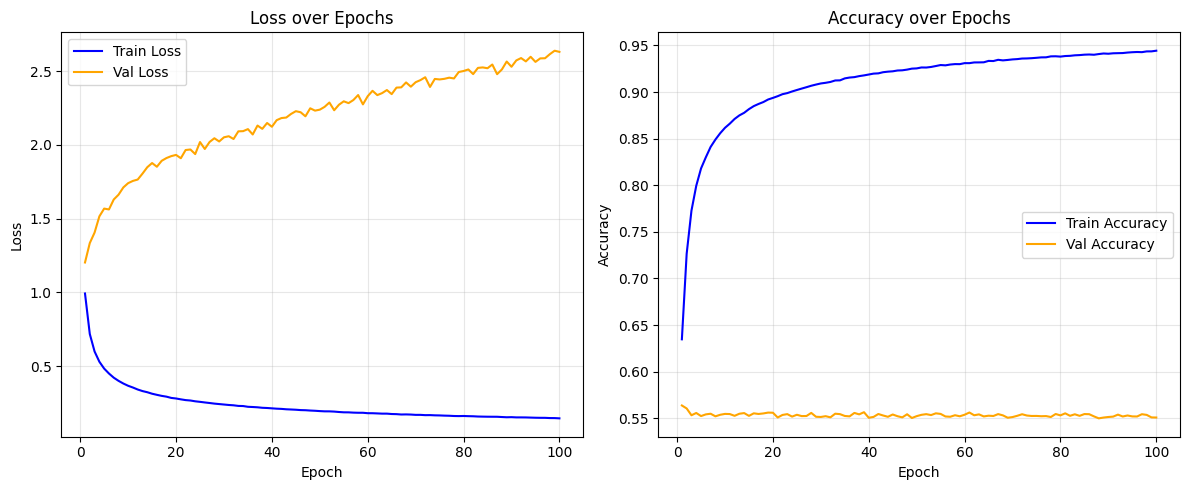

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path("./experiments/logs/giraffe_baseline_with_dropout_state/run_2025_12_28_giraffe_baseline_with_dropout_state_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [2]:
def vector_to_fen(vector):
    """
    Reconstructs a FEN string from the 775-dim bitboard vector.
    """
    # Standard mapping used in your feature engineering
    index_to_piece = {
        0: 'P', 1: 'N', 2: 'B', 3: 'R', 4: 'Q', 5: 'K',
        6: 'p', 7: 'n', 8: 'b', 9: 'r', 10: 'q', 11: 'k'
    }
    
    # 1. Setup Board
    board = chess.Board(None) # Empty board
    
    # 2. Place Pieces (Indices 0-767)
    for piece_idx in range(12):
        for square in range(64):
            idx = piece_idx * 64 + square
            if vector[idx] == 1:
                piece = chess.Piece.from_symbol(index_to_piece[piece_idx])
                board.set_piece_at(square, piece)
                
    # 3. Set Turn (Index 768)
    # 1.0 = White, 0.0 = Black
    board.turn = chess.WHITE if vector[768] == 1 else chess.BLACK
    
    # 4. Set Castling Rights (Indices 769-772)
    # 769: WK, 770: WQ, 771: BK, 772: BQ
    castling_fen = ""
    if vector[769] == 1: castling_fen += "K"
    if vector[770] == 1: castling_fen += "Q"
    if vector[771] == 1: castling_fen += "k"
    if vector[772] == 1: castling_fen += "q"
    if castling_fen == "": castling_fen = "-"
    
    board.set_castling_fen(castling_fen)
    
    # 5. En Passant (Index 773) and Check (774)
    # Note: We can't recover the exact EP square from a single bit, 
    # but for visualization, it doesn't matter.
    
    return board.fen()

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def generate_saliency_map(model, input_tensor, target_class):
    """
    input_tensor: Shape (1, 19, 8, 8) or (1, 775)
    target_class: The class index (0-6) you want to explain (e.g., the WRONG prediction)
    """
    model.eval()
    
    # 1. Enable Gradient Calculation for the Input (Crucial Step)
    input_tensor.requires_grad_()
    
    # 2. Forward Pass
    output = model(input_tensor)
    
    # 3. Focus on the specific class score we want to explain
    # (e.g., "Why did you predict Class 0?")
    score = output[0, target_class]
    
    # 4. Backward Pass (Calculate Gradients)
    score.backward()
    
    # 5. Get the Gradients (Sensitivity)
    # Shape matches input. e.g. (1, 19, 8, 8)
    gradients = input_tensor.grad.data.abs()
    
    # 6. Collapse Channels to get a single 8x8 Heatmap
    # For CNN (19, 8, 8) -> Take max across channels -> (8, 8)
    if len(gradients.shape) == 4:
        heatmap, _ = torch.max(gradients[0], dim=0)
    
    # For MLP (1, 775) -> Reshape first 768 bits to (12, 8, 8) then max
    else:
        # Extract just the board bits (0-768), ignore global bits
        board_bits = gradients[0, :768].view(12, 8, 8)
        heatmap, _ = torch.max(board_bits, dim=0)
        
    return heatmap

# --- Visualization Function ---
def plot_chess_heatmap(heatmap, fen_str):
    """Overlay the heatmap on a chess board"""
    heatmap = heatmap.numpy()
    
    plt.figure(figsize=(6, 6))
    
    # Use Seaborn to plot the heatmap
    # 'hot' colormap: Black/Red = High Attention, Yellow/White = Low Attention
    sns.heatmap(heatmap, cmap='hot', annot=False, cbar=True, square=True)
    
    plt.title(f"Model Attention Map\nFEN: {fen_str[:30]}...")
    plt.gca().invert_yaxis() # Match chess board orientation (Rank 1 at bottom)
    plt.show()

Analyzing failure at dataset index: 6183
Reconstructed FEN: 1r4k1/2p2r1p/1q1b1Pp1/pPNp2Pn/P3p2P/KP2Q2N/3B1P2/2n4R w - - 0 1
True Class Label: 4
Model Predicted: 1 (Error: 3 bins)


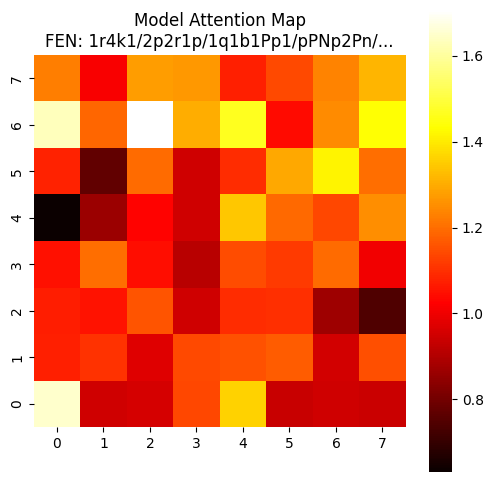

In [60]:
from pathlib import Path
import json
import numpy as np
import chess

import torch
import torch.nn as nn

class GiraffeBaselineWithDropoutWithState(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)

# A. Load Failure Indices
failure_path = Path("./experiments/results/giraffe_baseline_with_dropout_state/run_2025_12_28_giraffe_baseline_with_dropout_state_failure_indices.json")
with open(failure_path, 'r') as f:
    failures = json.load(f)

# Pick an index from the "3" bin (Errors off by 3 classes)
# Check if key "3" exists and has data
# --------------------------------------------------------------------------------------------------------------------------------------------------
target_error_bin = "3"
if target_error_bin in failures and failures[target_error_bin]:
    target_idx = failures[target_error_bin][400] # Pick the first failed case
    print(f"Analyzing failure at dataset index: {target_idx}")
else:
    raise ValueError(f"No failures found for bin {target_error_bin}")

# B. Load the Dataset Row
data_path = Path("./dataset_processed_clean_split_with_state/chess_state_bitboard_test.npz")
data = np.load(data_path)

# Extract vector and label
# Note: 'x' and 'y' are standard keys for np.savez, check your specific npz keys if this fails
input_vector = data['X'][target_idx] 
true_label = int(data['y'][target_idx])

# C. Reconstruct FEN
fen_str = vector_to_fen(input_vector)
print(f"Reconstructed FEN: {fen_str}")
print(f"True Class Label: {true_label}")

# D. Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = Path("./giraffe_baseline_with_dropout_state.pth")

model = GiraffeBaselineWithDropoutWithState(input_shape=775, hidden_units=2048, output_shape=7)
# Load weights (assuming state_dict was saved)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except:
    # Fallback if full model was saved instead of state_dict
    model = torch.load(model_path, map_location=device)

model.to(device)
model.eval()
# E. Generate Heatmap
# Prepare tensor
input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0).to(device)

# We usually want to explain the WRONG prediction (why did it pick that?) 
# or the TRUE label (what did it miss?).
# Let's see what the model actually predicts first:
with torch.no_grad():
    logits = model(input_tensor)
    predicted_class = torch.argmax(logits, dim=1).item()

print(f"Model Predicted: {predicted_class} (Error: {abs(predicted_class - true_label)} bins)")

# Visualize attention for the PREDICTED (wrong) class
heatmap = generate_saliency_map(model, input_tensor, target_class=predicted_class)
plot_chess_heatmap(heatmap.cpu(), fen_str)

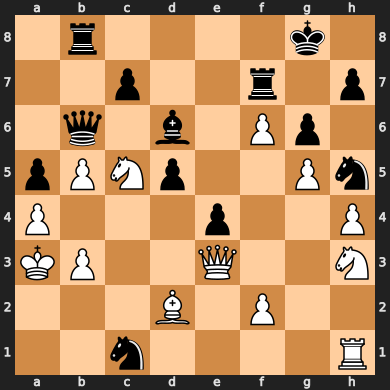

In [61]:
board = chess.Board(fen_str)
board

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_game_phase_performance(model, test_loader, device):
    model.eval()
    
    # Dictionary to store results: { piece_count: [correct_predictions, total_samples] }
    phase_stats = {i: [0, 0] for i in range(33)} # Max 32 pieces on board
    
    print("Analyzing performance across Game Phases...")
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            X_cpu = X.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(y_cpu)):
                # 1. Count Pieces (Sum of first 768 bits)
                # Note: This counts Kings too. 
                piece_count = int(np.sum(X_cpu[i, :768]))
                
                # 2. Record Correctness
                is_correct = 1 if preds_cpu[i] == y_cpu[i] else 0
                
                phase_stats[piece_count][0] += is_correct
                phase_stats[piece_count][1] += 1
                
    # --- PROCESS & PLOT ---
    
    counts = []
    accuracies = []
    
    # We aggregate slightly to avoid noise (e.g., group 3-5 pieces together)
    # But for a raw plot, let's just do Piece Count 3 to 32
    valid_piece_counts = sorted([k for k, v in phase_stats.items() if v[1] > 50]) # Filter rare counts
    
    for pc in valid_piece_counts:
        correct, total = phase_stats[pc]
        acc = correct / total
        counts.append(pc)
        accuracies.append(acc)
        
    # PLOT
    plt.figure(figsize=(10, 6))
    plt.plot(counts, accuracies, marker='o', linewidth=2, color='b')
    plt.title("Model Accuracy vs. Game Phase (Piece Count)")
    plt.xlabel("Number of Pieces on Board (Left = Endgame, Right = Opening)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.gca().invert_xaxis() # Standard Chess Style: Endgames (Low numbers) on the Right
    plt.show()
    
    return counts, accuracies

# Run it
# counts, accs = analyze_game_phase_performance(model, test_dataloader, device)